In [1]:
import math
import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [195]:
class SnakeExtended:
    """
    Should add in plotting and boundary condition specification methods.
    """

    def __init__(self, B, c, l, sigma, rho, mesh_points=50):
        self.g = -9.8
        self.B = B
        self.c = c
        self.sigma = sigma
        self.rho = rho
        self.lg = (-self.B / (self.rho * self.g)) ** (1 / 3)
        self.l = l
        self.x = np.linspace(0, 1, mesh_points)
        self.y = np.zeros((4, self.x.size))
        self.make_initial_guesses()

    def make_initial_guesses(self):
        """
        Initial parameter guesses for usual boundary conditions.
        """
        self.y[0, 0] = 0
        self.y[0, -1] = np.pi / 2
        self.y[1, -1] = 0
        self.y[2, -1] = 0
        self.y[3, -1] = 0
        dy_ds = np.exp(-((self.x - 0.25) ** 2) / 0.010)
        y_guess = (
            np.pi / 2 * si.cumtrapz(dy_ds, self.x, initial=0) / si.trapz(dy_ds, self.x)
        )
        d2y_ds2 = np.gradient(dy_ds, self.x, edge_order=2)
        d3y_ds3 = np.gradient(d2y_ds2, self.x, edge_order=2)
        self.y[0, :] = y_guess
        self.y[1, :] = dy_ds
        self.y[2, :] = d2y_ds2
        self.y[3, :] = d3y_ds3

    def fun_k(self, x, y, p):
        l = p[0]
        dy0_dx = y[1]
        dy1_dx = y[2]
        dy2_dx = y[3]
        dy3_dx = -(self.B + self.c) / (self.c * self.sigma ** 2) * y[2] + (
            self.rho * self.g * l ** 3
        ) / (self.c * self.sigma ** 2) * x * np.cos(y[0])
        # dy1_dx = (
        #     self.B * (-l / self.lg) ** 3 * x * np.cos(y[0]) / (self.B + self.c)
        # )  # need -g
        dy_dx = np.vstack((dy0_dx, dy1_dx, dy2_dx, dy3_dx))
        return dy_dx

    def bc(self, ya, yb, p):
        res1 = ya[0]
        res2 = yb[0] - np.pi / 2
        res3 = yb[1]
        res4 = yb[2]
        res5 = yb[3]
        residuals = np.array([res1, res2, res3, res4, res5])
        return residuals

    def solve(self, verbose=0):
        self.sol = si.solve_bvp(
            fun=self.fun_k, bc=self.bc, x=self.x, y=self.y, p=[self.l], verbose=verbose
        )
        self.l = self.sol.p[0]
        self.x_pos = si.cumtrapz(self.l * np.cos(self.sol.y[0]), self.sol.x, initial=0)
        self.y_pos = si.cumtrapz(self.l * np.sin(self.sol.y[0]), self.sol.x, initial=0)

    def cost(self, alpha=0.5):
        height_term = self.y_pos[-1] / self.l
        self.height_cost = -alpha * height_term
        work_term = self.c / (2 * self.B) * si.trapz(self.sol.y[1] ** 2, self.sol.x)
        self.work_cost = (1 - alpha) * work_term
        cost = self.height_cost + self.work_cost
        return cost

In [347]:
snake = SnakeExtended(B=1, c=0.1, l=1, sigma=0.1, rho=1, mesh_points=60)

In [354]:
rho = 1
l = 3
B = 1
cs = np.linspace(1, 1000 * B, 10)
# cs = np.linspace(0.001*B, B, 10)
costs = []
ls = []
xs = []
ys = []
moment_at_base = []
for c in cs:
    snake = SnakeExtended(B=B, c=c, l=l, sigma=0.1, rho=rho, mesh_points=50)
    snake.solve()
    if snake.sol.status != 0:
        print(f"Failed! with c = {round(c, 3)} message says {snake.sol.message}")
    cost = snake.cost(alpha=0.9)
    # print(f"c is {round(c,3)}, Work cost is {round(snake.work_cost,3)}, height cost is {round(snake.height_cost,3)}")
    costs.append(cost)
    ls.append(snake.l)
    xs.append(snake.x_pos)
    ys.append(snake.y_pos)
    base_moment = (snake.B + snake.c) / (snake.l) * snake.sol.y[1][0]
    moment_at_base.append(base_moment)

moment_at_base = np.array(moment_at_base)
costs = np.array(costs)
ls = np.array(ls)

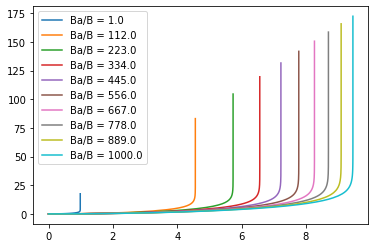

In [355]:
for i in range(cs.size):
    plt.plot(xs[i], ys[i], label=f"Ba/B = {round(cs[i], 0)}")
    plt.legend()

In [356]:
cost_regr = linregress(cs, costs)
cost_slope = cost_regr.slope
cost_int = cost_regr.intercept

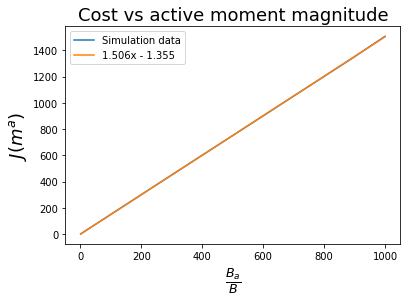

In [357]:
plt.plot(cs, costs, label="Simulation data")
plt.plot(
    cs,
    cost_slope * cs + cost_int,
    label=f"{round(cost_slope,3)}x - {-round(cost_int,3)}",
)
plt.legend()
plt.xlabel(R"$\frac{B_a}{B}$", fontsize=18)
plt.ylabel(r"$J(m^a)$", fontsize=18)
plt.title("Cost vs active moment magnitude", fontsize=18)
plt.show()

In [358]:
c_data = np.log(cs)
l_data = np.log(ls / snake.lg)
length_reg = linregress(c_data, l_data)
m, b = length_reg.slope, length_reg.intercept

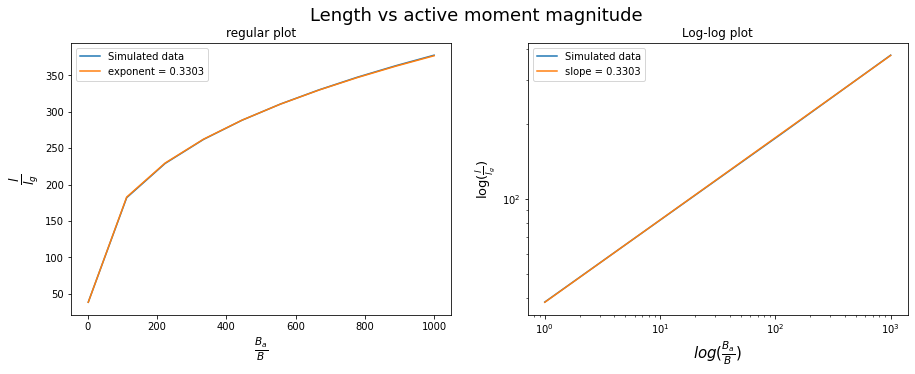

In [359]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Length vs active moment magnitude", fontsize=18)

axs[0].plot(cs, ls / snake.lg, label="Simulated data")
axs[0].plot(cs, np.exp(b) * cs ** m, label=f"exponent = {round(m, 4)}")
axs[0].legend()
axs[0].set_title("regular plot")
axs[0].set_xlabel(r"$\frac{B_a}{B}$", fontsize=15)
axs[0].set_ylabel(r"$\frac{l}{l_g}$", fontsize=18)


axs[1].loglog(cs, ls / snake.lg, label="Simulated data")
axs[1].loglog(cs, np.exp(b) * cs ** m, label=f"slope = {round(m,4)}")
axs[1].legend()
axs[1].set_title("Log-log plot")
axs[1].set_xlabel(r"$log(\frac{B_a}{B})$", fontsize=15)
axs[1].set_ylabel(r"log($\frac{l}{l_g})$", fontsize=13)
plt.show()

In [360]:
l_data = np.log(ls / snake.lg)
mom_data = np.log(moment_at_base)
moment_reg = linregress(l_data, mom_data)
m, b = moment_reg.slope, moment_reg.intercept

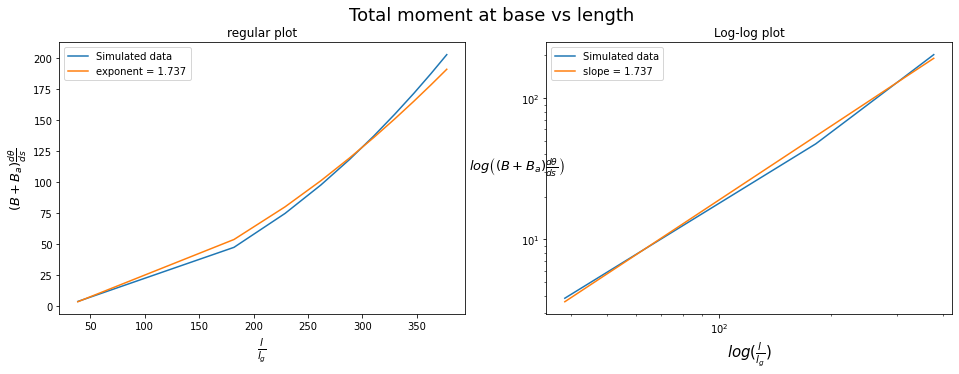

In [361]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Total moment at base vs length", fontsize=18)

axs[0].plot(ls / snake.lg, moment_at_base, label="Simulated data")
axs[0].plot(
    ls / snake.lg, np.exp(b) * (ls / snake.lg) ** m, label=f"exponent = {round(m, 3)}"
)
axs[0].legend()
axs[0].set_title("regular plot")
axs[0].set_xlabel(r"$\frac{l}{l_g}$", fontsize=15)
axs[0].set_ylabel(r"$(B+B_a)\frac{d\theta}{ds}$", fontsize=13, rotation=90)


axs[1].loglog(ls / snake.lg, moment_at_base, label="Simulated data")
axs[1].loglog(
    ls / snake.lg, np.exp(b) * (ls / snake.lg) ** m, label=f"slope = {round(m,3)}"
)
axs[1].legend()
axs[1].set_title("Log-log plot")
axs[1].set_xlabel(r"$log(\frac{l}{l_g})$", fontsize=15)
axs[1].set_ylabel(
    r"$log\left((B+B_a)\frac{d\theta}{ds}\right)$", fontsize=13, rotation=0
)
plt.show()

In [362]:
max_x = np.array([x[-1] for x in xs])
x_regress = linregress(ls / snake.lg, max_x)
x_slope, x_intercept = x_regress.slope, x_regress.intercept


max_y = np.array([y[-1] for y in ys])
y_regress = linregress(ls / snake.lg, max_y)
y_slope, y_intercept = y_regress.slope, y_regress.intercept

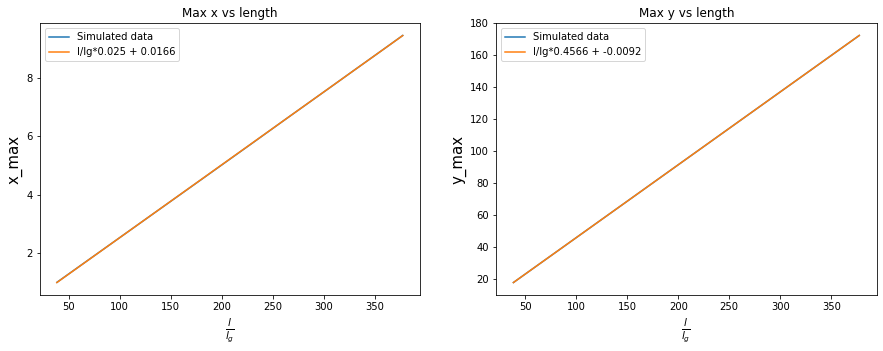

In [363]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(ls / snake.lg, max_x, label="Simulated data")
axs[0].plot(
    ls / snake.lg,
    x_slope * ls / snake.lg + x_intercept,
    label=f"l/lg*{round(x_slope, 4)} + {round(x_intercept, 4)}",
)
axs[0].legend()
axs[0].set_xlabel(r"$\frac{l}{l_g}$", fontsize=15)
axs[0].set_ylabel(r"x_max", fontsize=15)
axs[0].set_title("Max x vs length")

axs[1].plot(ls / snake.lg, max_y, label="Simulated data")
axs[1].plot(
    ls / snake.lg,
    y_slope * ls / snake.lg + y_intercept,
    label=f"l/lg*{round(y_slope, 4)} + {round(y_intercept, 4)}",
)
axs[1].legend()
axs[1].set_xlabel(r"$\frac{l}{l_g}$", fontsize=15)
axs[1].set_ylabel(r"y_max", fontsize=15)
axs[1].set_title("Max y vs length")

plt.show()

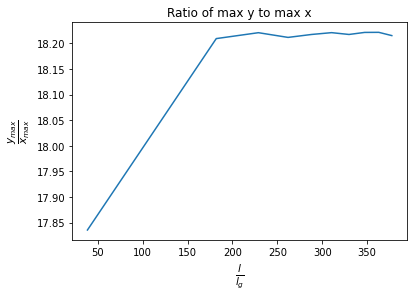

In [364]:
plt.plot(ls / snake.lg, max_y / max_x)
plt.title("Ratio of max y to max x")
plt.xlabel(r"$\frac{l}{l_g}$", fontsize=15)
plt.ylabel(r"$\frac{y_{max}}{x_{max}}$", fontsize=15, rotation=90)
plt.ylim()
plt.show()

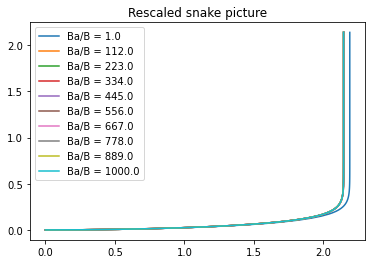

In [365]:
for i in range(cs.size):
    plt.plot(
        xs[i] / (ls[i] * x_slope),
        ys[i] / (ls[i] * y_slope),
        label=f"Ba/B = {round(cs[i], 0)}",
    )
    plt.legend()
plt.title("Rescaled snake picture")
plt.show()

In [366]:
log_cs = np.log(cs / B)
log_max_y = np.log(max_y)
log_max_x = np.log(max_x)

log_y_regress = linregress(log_cs, log_max_y)
max_y_m, max_y_b = log_y_regress.slope, log_y_regress.intercept


log_x_regress = linregress(log_cs, log_max_x)
max_x_m, max_x_b = log_x_regress.slope, log_x_regress.intercept

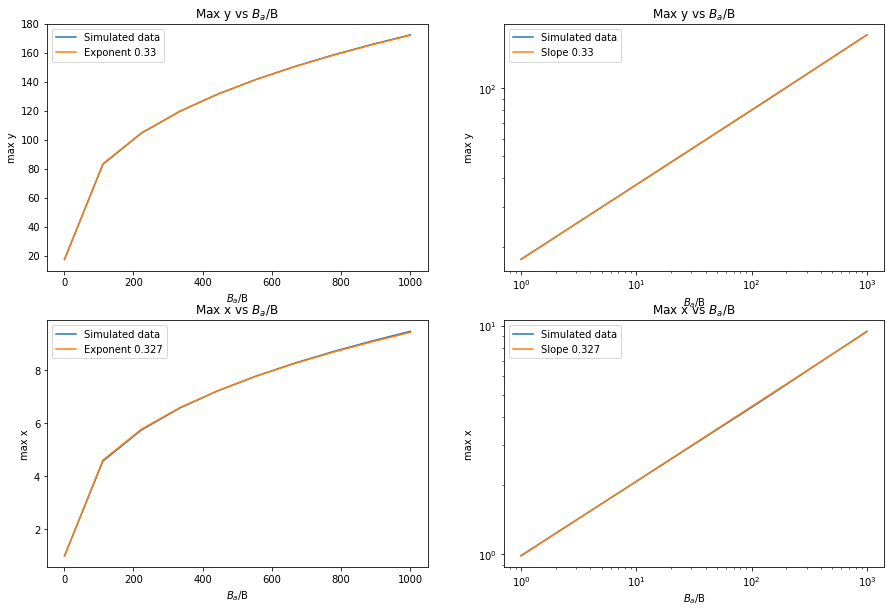

In [367]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0, 0].plot(cs / B, max_y, label="Simulated data")
ax[0, 0].plot(
    cs / B, np.exp(max_y_b) * (cs / B) ** max_y_m, label=f"Exponent {round(max_y_m, 3)}"
)
ax[0, 1].loglog(cs / B, max_y, label="Simulated data")
ax[0, 1].loglog(
    cs / B, np.exp(max_y_b) * (cs / B) ** max_y_m, label=f"Slope {round(max_y_m, 3)}"
)

for a in ax[0]:
    a.set_xlabel(r"$B_a$/B")
    a.set_ylabel("max y")
    a.set_title(r"Max y vs $B_a$/B")
    a.legend()


ax[1, 0].plot(cs / B, max_x, label="Simulated data")
ax[1, 0].plot(
    cs / B, np.exp(max_x_b) * (cs / B) ** max_x_m, label=f"Exponent {round(max_x_m, 3)}"
)
ax[1, 1].loglog(cs / B, max_x, label="Simulated data")
ax[1, 1].loglog(
    cs / B, np.exp(max_x_b) * (cs / B) ** max_x_m, label=f"Slope {round(max_x_m, 3)}"
)

for a in ax[1]:
    a.set_xlabel(r"$B_a$/B")
    a.set_ylabel("max x")
    a.set_title(r"Max x vs $B_a$/B")
    a.legend()

plt.show()